In [ ]:
## Load libraries
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import os
from sklearn.metrics import mean_absolute_error, r2_score
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.float_format', '{:.0f}'.format)

In [ ]:
# === 1. Remover outliers IQR inicial por cliente ===
def remover_outliers_iqr_por_cliente(df, col_consumo="qtd_consumo_medido_agua"):
    resultados = []
    for cliente_id, grupo in df.groupby("id_fornecimento"):
        grupo = grupo.copy()
        q1 = grupo[col_consumo].quantile(0.15)
        q3 = grupo[col_consumo].quantile(0.85)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr
        grupo_filtrado = grupo[(grupo[col_consumo] >= lim_inf) & (grupo[col_consumo] <= lim_sup)].copy()
        resultados.append(grupo_filtrado)
    return pd.concat(resultados, ignore_index=True)

# === 2. Calcular media móvil (solo en datos filtrados) ===
def calcular_media_movel(df_filtrado, window=3, col_consumo="qtd_consumo_medido_agua"):
    df_filtrado = df_filtrado.sort_values(["id_fornecimento", "data"])
    df_filtrado[f"media_movel_{window}"] = (
        df_filtrado.groupby("id_fornecimento")[col_consumo]
        .transform(lambda x: x.rolling(window=window, center=False).mean())
    )
    return df_filtrado

# === 3. Aplicar media móvil al dataset original ===
def aplicar_media_movel_en_original(df_original, df_com_media, window=6):
    col_media = f"media_movel_{window}"
    df_merge = df_original.merge(
        df_com_media[["id_fornecimento", "data", col_media]],
        on=["id_fornecimento", "data"],
        how="left"
    )
    df_merge = df_merge.sort_values(["id_fornecimento", "data"])
    df_merge[col_media] = df_merge.groupby("id_fornecimento")[col_media].transform(lambda x: x.ffill())
    return df_merge

# === 4. Detectar outliers finales con Z-Score ===
def detectar_outliers_final_zscore(df, col_consumo="qtd_consumo_medido_agua", window=6, z_threshold=1.5):
    col_media = f"media_movel_{window}"
    df = df.copy()
    df["residuo_mm"] = df[col_consumo] - df[col_media]

    resultados = []

    for cliente_id, grupo in df.groupby("id_fornecimento"):
        grupo = grupo.copy()
        media_residuo = grupo["residuo_mm"].mean()
        std_residuo = grupo["residuo_mm"].std()
        std_residuo = max(std_residuo, 1e-6)

        grupo["z_score_residuo"] = (grupo["residuo_mm"] - media_residuo) / std_residuo
        grupo["outlier_MM"] = grupo["z_score_residuo"].abs() > z_threshold
        grupo["z_threshold"] = z_threshold  # por si se quiere graficar
        resultados.append(grupo)

    return pd.concat(resultados, ignore_index=True)

# === Gráfico Paso 1: Remoción IQR inicial ===
def graficar_IQR_inicial(df_original, df_filtrado, cliente_id, col_consumo="qtd_consumo_medido_agua"):
    df_orig = df_original[df_original["id_fornecimento"] == cliente_id].copy().sort_values("data")
    df_clean = df_filtrado[df_filtrado["id_fornecimento"] == cliente_id].copy()
    removidos = df_orig[~df_orig.index.isin(df_clean.index)]

    plt.figure(figsize=(14, 5))
    plt.plot(df_orig["data"], df_orig[col_consumo], label="Consumo original", color="lightgray")
    plt.scatter(removidos["data"], removidos[col_consumo], color="black", label="Removidos (IQR inicial)", zorder=2)
    plt.scatter(df_clean["data"], df_clean[col_consumo], color="blue", label="Conservados", zorder=3)

    plt.title(f"Paso 1: IQR inicial - Cliente {int(cliente_id)}")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Gráfico Paso 3: Outliers finales con media móvil + z-score ===
def graficar_outliers_finais(df_final, cliente_id, window=3, z_threshold=1.5, col_consumo="qtd_consumo_medido_agua"):
    df_cliente = df_final[df_final["id_fornecimento"] == cliente_id].copy().sort_values("data")
    col_media = f"media_movel_{window}"

    # Límites del z-score traducidos al eje y (consumo estimado)
    media_res = df_cliente["residuo_mm"].mean()
    std_res = df_cliente["residuo_mm"].std()
    lim_sup = df_cliente[col_media] + (media_res + z_threshold * std_res)
    lim_inf = df_cliente[col_media] + (media_res - z_threshold * std_res)

    plt.figure(figsize=(14, 5))
    plt.plot(df_cliente["data"], df_cliente[col_consumo], label="Consumo original", color="lightgray", zorder=1)
    plt.plot(df_cliente["data"], df_cliente[col_media], label=f"Média móvel ({window})", color="orange", linestyle="--", zorder=2)
    plt.plot(df_cliente["data"], lim_sup, color="green", linestyle=":", label=f"Umbral superior (+{z_threshold}σ)")
    plt.plot(df_cliente["data"], lim_inf, color="green", linestyle=":", label=f"Umbral inferior (-{z_threshold}σ)")

    outliers = df_cliente[df_cliente["outlier_MM"]]
    plt.scatter(outliers["data"], outliers[col_consumo], color="red", label="Outliers finales", zorder=3)

    plt.title(f"Paso 3: Outliers finales sobre residuo - Cliente {int(cliente_id)}")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Data transaccional
transaccional = "../data/MOV_FATURA_ATC581.csv"
fatura = pd.read_csv(transaccional, encoding="ISO-8859-1", delimiter=";")
transaccional2 = "../data/MOV_LEITURA_ATC581.csv"
leitura = pd.read_csv(transaccional2, encoding="ISO-8859-1", delimiter=";")
archivo = "../data/raw_complete_data/Reformas.csv"
reformas = pd.read_csv(archivo, delimiter=";", on_bad_lines="skip")  # Si usa punto y coma

/var/folders/6t/wsvrnby90bjc6357kyzjpp5mvbl7g2/T/ipykernel_55770/1189159684.py:3: DtypeWarning: Columns (4,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  fatura = pd.read_csv(transaccional, encoding="ISO-8859-1", delimiter=";")
/var/folders/6t/wsvrnby90bjc6357kyzjpp5mvbl7g2/T/ipykernel_55770/1189159684.py:5: DtypeWarning: Columns (5,11,13,18,19,20,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  leitura = pd.read_csv(transaccional2, encoding="ISO-8859-1", delimiter=";")
/var/folders/6t/wsvrnby90bjc6357kyzjpp5mvbl7g2/T/ipykernel_55770/1189159684.py:7: DtypeWarning: Columns (1,14,21,30,31,44,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  reformas = pd.read_csv(archivo, delimiter=";", on_bad_lines="skip")  # Si usa punto y coma


In [ ]:
merged_df = fatura.merge(leitura, on="ID_FATURA", how="outer", indicator=True)
df = merged_df.copy()

In [ ]:
## Fix data types
df['AAMM_COMPETENCIA'] = pd.to_numeric(df['AAMM_COMPETENCIA'], errors='coerce')
df['QTD_CONSUMO_MEDIDO_AGUA'] = df['QTD_CONSUMO_MEDIDO_AGUA'].astype(str).str.replace(',', '.')
df['QTD_CONSUMO_MEDIDO_AGUA'] = pd.to_numeric(df['QTD_CONSUMO_MEDIDO_AGUA'], errors='coerce')

df['VLR_FATURADO_TOTAL'] = df['VLR_FATURADO_TOTAL'].astype(str).str.replace(',', '.')
df['VLR_FATURADO_TOTAL'] = pd.to_numeric(df['VLR_FATURADO_TOTAL'], errors='coerce')

df['QTD_CONSUMO_FATURADO_AGUA'] = df['QTD_CONSUMO_FATURADO_AGUA'].astype(str).str.replace(',', '.')
df['QTD_CONSUMO_FATURADO_AGUA'] = pd.to_numeric(df['QTD_CONSUMO_FATURADO_AGUA'], errors='coerce')

df['CONSUMO_MEDIO'] = df['CONSUMO_MEDIO'].astype(str).str.replace(',', '.')
df['CONSUMO_MEDIO'] = pd.to_numeric(df['CONSUMO_MEDIO'], errors='coerce')
#Create data column
# Asegurarse de que la columna existe y convertir a string
df['AAMM_COMPETENCIA'] = df['AAMM_COMPETENCIA'].astype(str)

# Reemplazar valores inválidos como 'nan', 'NaT', etc. por NaN
df['AAMM_COMPETENCIA'] = df['AAMM_COMPETENCIA'].replace('nan', pd.NA)

# Eliminar filas con AAMM_COMPETENCIA nulo o inválido (opcional)
df = df[df['AAMM_COMPETENCIA'].notna()]

# Extraer año y mes
df['ANO'] = df['AAMM_COMPETENCIA'].str[:4].astype(int)
df['MES'] = df['AAMM_COMPETENCIA'].str[4:6].astype(int)

# Crear columna combinada y objeto tipo fecha
df['ANO_MES'] = df['ANO'].astype(str) + '-' + df['MES'].astype(str).str.zfill(2)
df['DATA'] = pd.to_datetime(df['ANO_MES'], format='%Y-%m', errors='coerce')

In [ ]:
# Asegurarse de que las columnas estén en formato datetime
reformas["DATA_INICIO_PROCESSO"] = pd.to_datetime(reformas["DATA_INICIO_PROCESSO"], errors="coerce")
reformas["DATA_FIM_PROCESSO"] = pd.to_datetime(reformas["DATA_FIM_PROCESSO"], errors="coerce")

In [ ]:
#Filtros
df_2 = df[(df['ANO'] >= 2021) & (df['ANO'] <= 2024)]
df_3 = df_2[df_2['VLR_FATURADO_TOTAL'] > 0]
df_final = df_3[df_3['TP_LEITURA_LOGICO'].isin(['LG', 'LR', 'MA'])]
df_final = df_final[df_final['ST_FATURA'] != 'ANNULLATO']

df = df_final.copy()

In [ ]:
## Filtros datos
reformas['reformo'] = 1
reformas = reformas[reformas['DATA_FIM_PROCESSO'] <= '2024-12-31']
#Merge datos reforma
merge_reforma_df = df.merge(
    reformas,
    left_on="ID_FATURA",
    right_on="DOCUMENTO",
    how="left",
    indicator=False
)
merge_reforma_df['reformo'] = merge_reforma_df['reformo'].fillna(0)


In [ ]:
df_media = merge_reforma_df.copy()
df_media.columns = df_media.columns.str.lower()

In [ ]:
df_media

,uk_mov_fatura,id_fatura,cd_fatura,ano_fatura,cd_seccional,cd_segmento,id_fornecimento,id_sujeito,cd_atc,cd_gr_faturamento,st_fatura,tp_fatura,tp_documento_logico,dt_emissao_fatura,vlr_faturado_total,qtd_consumo_faturado_agua,qtd_consumo_faturado_esgoto,qtd_consumo_faturado_end,ch_documento,aamm_competencia,dt_inclusao_x,dt_insercao_x,id_leitura,id_pde,id_hidrometro_leitura,cd_gr_leitura,cd_operador,st_leitura,tp_leitura_logico,cd_nao_leitura,cd_origem_leitura,nr_tarefa,nr_leitura_atual,dh_leitura_atual,nr_leitura_anterior,dh_leitura_anterior,qtd_dias,ds_obs_geral,fl_alta_baixa_consumo,qtd_consumo_medido_agua,qtd_consumo_medido_esgoto,qtd_consumo_medido_end,nr_meses_sem_leitura,consumo_medio_x,dt_inclusao_y,dt_insercao_y,cd_contrato,nm_contrato,_merge,ano,mes,ano_mes,data,sujeito,pde,fornecimento,data_fim_processo,operador,categoria,id_processo,aprovador,tipo_utilizacao,atc,data_inicio_processo,tipo_processo,motivo_reforma,valor_total_inicial,valor_total_final,faixa da reforma (r$),valor_da_reforma,documento,tipo vinculo,leitura_inicial,leitura_final,tipo_de_leitura,dias_de_consumo,unidade_acatante,data_vencimento,data_emissao,arsesp_reconhece,dif_dias_vencimento_dt_fim_processo,dif_dias_emissao_dt_fim_processo,prazo_arsesp,latitude,longitude,consumo_medio_y,situacao,motivadores,origem,superintendencia,atc_,região,municipio,ds_atc,sg,faixa_tempo,situaçao_reforma,tipo,qt_fornecimentos,nomecliente,dif_dias_inicio_fim_processo,outlier,google_maps,jornada do fornecimento,street view,ds_logradouro,nr_logradouro,compl_logradouro,bairro,cep,ds_data_inicio_processo,ds_data_fim_processo,encerrador,nota_acatamento,unidade_executante,nome_contratada,nome_leiturista,cod_leitura,terminal_ip_operador,terminal_ip_aprovador,terminal_ip_encerrador,operadores_reincidentes,aprovadores_reincidentes,nome_reincidentes,reformanomes,ano_emissao,ano_mes_emissao,tp_mercado,_reforma_parcial_total,codigo_contratada,localizade_terminal_aprovador,reformo
0,39481438,202110064154SOR02792202106,10064154,2021,SOR,0,86040363137562,411822,581,F_COM_04,CONTABEFFETTIVO,FATURAMENTO,B,21/06/21,86,13,13,0,2792,202106.0,17/07/21,NaN,vt9EiLU2E3Dd78Jr-508-202106,2000005617,Y20T471567,L_COMUM,NaN,FAT,MA,-1,4,NaN,85,07/06/21,72,07/05/21,31,NaN,NaN,13,13,0,0,13,22/06/21,NaN,NaN,NaN,both,2021,6,2021-06,2021-06-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,420506786,202110064155SOR0449202106,10064155,2021,SOR,0,86040363457460,415729,581,F_COM_04,CONTABEFFETTIVO,FATURAMENTO,B,21/06/21,31,10,0,0,449,202106.0,23/09/23,NaN,00B6D70000b-535-202106,467221570,Y13L688021,L_COMUM,NaN,FAT,LG,-1,-1,NaN,487,07/06/21,497,07/04/21,61,NaN,NaN,0,0,0,0,0,23/09/23,NaN,NaN,NaN,both,2021,6,2021-06,2021-06-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,39481440,202110064156SOR0449202106,10064156,2021,SOR,0,86040364256601,421555,581,F_COM_04,CONTABEFFETTIVO,FATURAMENTO,B,21/06/21,396,31,31,0,449,202106.0,17/07/21,NaN,WS32Fo7QVrRHiMZM-519-202106,2000008138,A19L693761,L_COMUM,NaN,FAT,MA,-1,4,NaN,83,07/06/21,52,07/05/21,31,NaN,NaN,31,31,0,0,30,22/06/21,NaN,NaN,NaN,both,2021,6,2021-06,2021-06-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,39481441,202110064157SOR08202106,10064157,2021,SOR,0,860403650

In [ ]:
# --- 0. Parámetros generales
cliente_id_objetivo = 43965709001
window = 6  # ventana de la media móvil
col_consumo = "qtd_consumo_medido_agua"

In [ ]:
df = df_media.sort_values(by=["id_fornecimento", "data", "tp_fatura"], ascending=[True, True, False]).drop_duplicates(subset=["id_fornecimento", "data"], keep="first")

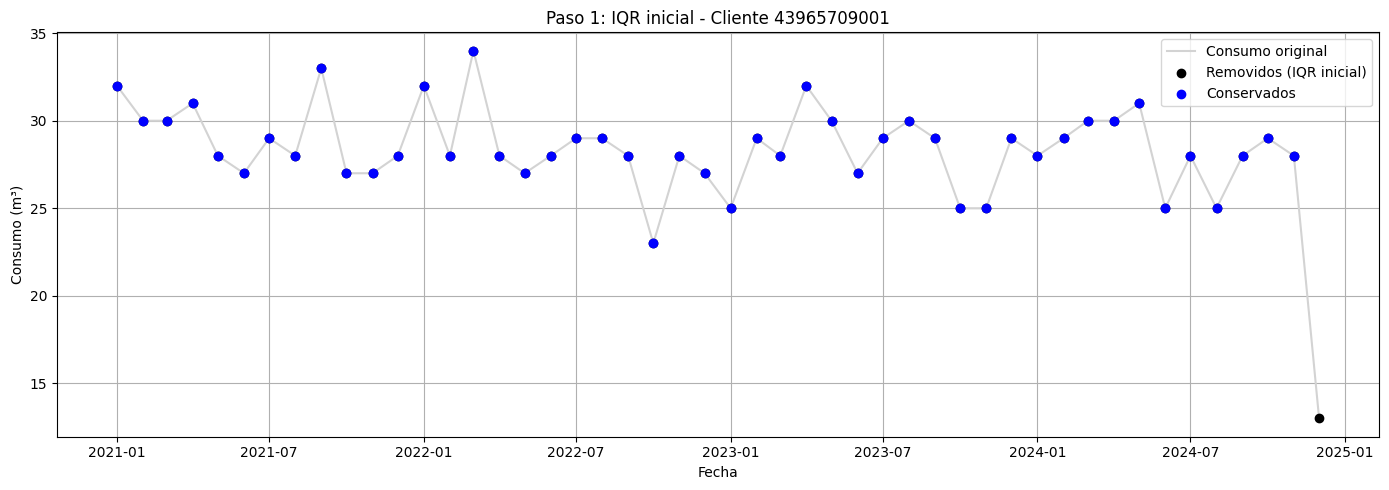

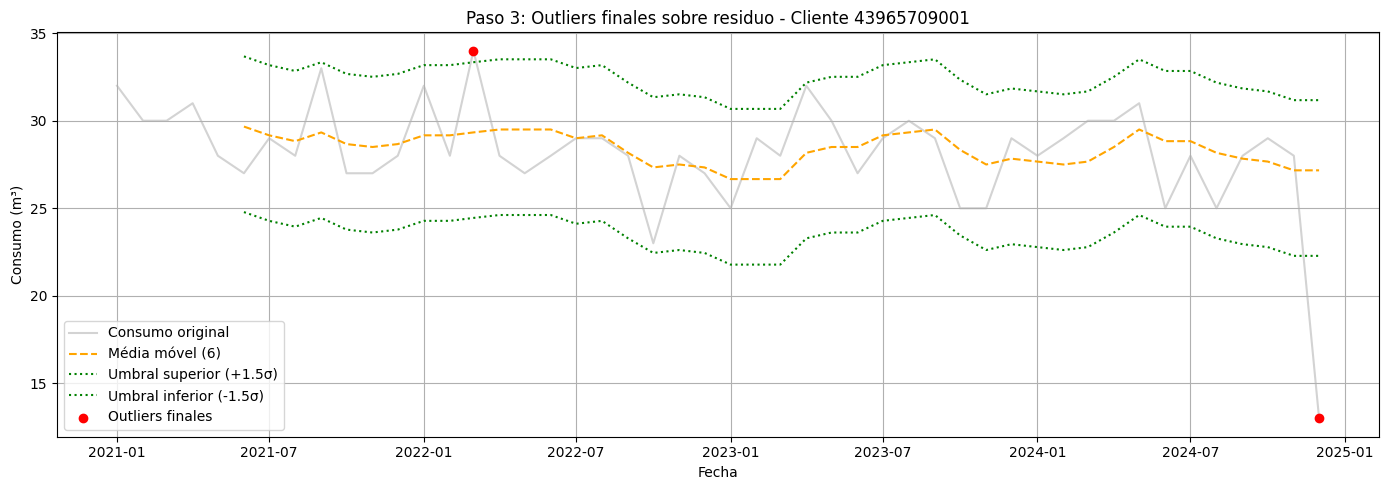

In [ ]:
df_sin_outliers_iniciales = remover_outliers_iqr_por_cliente(df, col_consumo=col_consumo)
graficar_IQR_inicial(df, df_sin_outliers_iniciales, cliente_id_objetivo)
df_media_movel = calcular_media_movel(df_sin_outliers_iniciales, window=window, col_consumo=col_consumo)
df_con_media = aplicar_media_movel_en_original(df, df_media_movel, window=window)
df_resultado = detectar_outliers_final_zscore(df_con_media, col_consumo=col_consumo, window=window, z_threshold=1.5)
graficar_outliers_finais(df_resultado, cliente_id_objetivo, window=window)

In [ ]:
df_resultado

,uk_mov_fatura,id_fatura,cd_fatura,ano_fatura,cd_seccional,cd_segmento,id_fornecimento,id_sujeito,cd_atc,cd_gr_faturamento,st_fatura,tp_fatura,tp_documento_logico,dt_emissao_fatura,vlr_faturado_total,qtd_consumo_faturado_agua,qtd_consumo_faturado_esgoto,qtd_consumo_faturado_end,ch_documento,aamm_competencia,dt_inclusao_x,dt_insercao_x,id_leitura,id_pde,id_hidrometro_leitura,cd_gr_leitura,cd_operador,st_leitura,tp_leitura_logico,cd_nao_leitura,cd_origem_leitura,nr_tarefa,nr_leitura_atual,dh_leitura_atual,nr_leitura_anterior,dh_leitura_anterior,qtd_dias,ds_obs_geral,fl_alta_baixa_consumo,qtd_consumo_medido_agua,qtd_consumo_medido_esgoto,qtd_consumo_medido_end,nr_meses_sem_leitura,consumo_medio_x,dt_inclusao_y,dt_insercao_y,cd_contrato,nm_contrato,_merge,ano,mes,ano_mes,data,sujeito,pde,fornecimento,data_fim_processo,operador,categoria,id_processo,aprovador,tipo_utilizacao,atc,data_inicio_processo,tipo_processo,motivo_reforma,valor_total_inicial,valor_total_final,faixa da reforma (r$),valor_da_reforma,documento,tipo vinculo,leitura_inicial,leitura_final,tipo_de_leitura,dias_de_consumo,unidade_acatante,data_vencimento,data_emissao,arsesp_reconhece,dif_dias_vencimento_dt_fim_processo,dif_dias_emissao_dt_fim_processo,prazo_arsesp,latitude,longitude,consumo_medio_y,situacao,motivadores,origem,superintendencia,atc_,região,municipio,ds_atc,sg,faixa_tempo,situaçao_reforma,tipo,qt_fornecimentos,nomecliente,dif_dias_inicio_fim_processo,outlier,google_maps,jornada do fornecimento,street view,ds_logradouro,nr_logradouro,compl_logradouro,bairro,cep,ds_data_inicio_processo,ds_data_fim_processo,encerrador,nota_acatamento,unidade_executante,nome_contratada,nome_leiturista,cod_leitura,terminal_ip_operador,terminal_ip_aprovador,terminal_ip_encerrador,operadores_reincidentes,aprovadores_reincidentes,nome_reincidentes,reformanomes,ano_emissao,ano_mes_emissao,tp_mercado,_reforma_parcial_total,codigo_contratada,localizade_terminal_aprovador,reformo,media_movel_6,residuo_mm,z_score_residuo,outlier_MM,z_threshold
0,17695936,2021408907SOR02793202101,408907,2021,SOR,0,43956114002,434880,581,F_COM_09,CONTABEFFETTIVO,FATURAMENTO,B,12/01/21,260,38,38,0,2793,202101.0,13/01/21,NaN,0051F90007c-2789-202101,43956114,A18L700961,L_COMUM,NaN,FAT,LG,-1,-1,NaN,649,12/01/21,611,12/12/20,31,NaN,NaN,38,38,0,0,33,12/01/21,NaN,NaN,NaN,both,2021,1,2021-01,2021-01-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,False,2
1,78463729,20212104356SOR02793202103,2104356,2021,SOR,0,43956114002,434880,581,F_COM_09,INVIATO_STA,FATURAMENTO,B,13/03/21,203,31,31,0,2793,202103.0,06/11/21,NaN,006A1B000a0-2789-202103,43956114,A18L700961,L_COMUM,NaN,FAT,LG,-1,-1,NaN,710,13/03/21,679,11/02/21,30,NaN,NaN,31,31,0,0,34,21/03/21,NaN,NaN,NaN,both,2021,3,2021-03,2021-03-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,False,2
2,22898926,20213131103SOR02793202104,3131103,2021,SOR,0,43956114002,434880,581,F_COM_09,CONTABEFFETTIVO,FATURAMENTO,B,13/04/21,243,36,36,0,2793,202104.0,14/04/21,NaN,0077E70007b-2789-202104,43956114,A18L700961,L_COMUM,NaN,FAT,LG,-1,-1,NaN,746,13/04/21,710,13/03/21,31,NaN,NaN,36,36,0,0,33,13/04/21,NaN,NaN,NaN,both,2021,4,2021-04,2021-04-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
ids_sin_outliers = (
    df_resultado.groupby("id_fornecimento")["outlier_MM"]
    .sum()
    .reset_index()
)


In [ ]:
cliente_sin_outlier = ids_sin_outliers.sample(1, random_state=42).iloc[0]

df_cliente_limpio = df_resultado[df_resultado["id_fornecimento"] == cliente_sin_outlier]

print(f"✅ Cliente sin outliers: {cliente_sin_outlier}")
display(df_cliente_limpio[["data", "qtd_consumo_medido_agua", "media_movel_6", "residuo_mm", "z_score_residuo", "outlier_MM"]])

ValueError: Can only compare identically-labeled Series objects

➡️ Paso 1: Datos SIN outliers iniciales (IQR)


,uk_mov_fatura,id_fatura,cd_fatura,ano_fatura,cd_seccional,cd_segmento,id_fornecimento,id_sujeito,cd_atc,cd_gr_faturamento,st_fatura,tp_fatura,tp_documento_logico,dt_emissao_fatura,vlr_faturado_total,qtd_consumo_faturado_agua,qtd_consumo_faturado_esgoto,qtd_consumo_faturado_end,ch_documento,aamm_competencia,dt_inclusao_x,dt_insercao_x,id_leitura,id_pde,id_hidrometro_leitura,cd_gr_leitura,cd_operador,st_leitura,tp_leitura_logico,cd_nao_leitura,cd_origem_leitura,nr_tarefa,nr_leitura_atual,dh_leitura_atual,nr_leitura_anterior,dh_leitura_anterior,qtd_dias,ds_obs_geral,fl_alta_baixa_consumo,qtd_consumo_medido_agua,qtd_consumo_medido_esgoto,qtd_consumo_medido_end,nr_meses_sem_leitura,consumo_medio_x,dt_inclusao_y,dt_insercao_y,cd_contrato,nm_contrato,_merge,ano,mes,ano_mes,data,sujeito,pde,fornecimento,data_fim_processo,operador,categoria,id_processo,aprovador,tipo_utilizacao,atc,data_inicio_processo,tipo_processo,motivo_reforma,valor_total_inicial,valor_total_final,faixa da reforma (r$),valor_da_reforma,documento,tipo vinculo,leitura_inicial,leitura_final,tipo_de_leitura,dias_de_consumo,unidade_acatante,data_vencimento,data_emissao,arsesp_reconhece,dif_dias_vencimento_dt_fim_processo,dif_dias_emissao_dt_fim_processo,prazo_arsesp,latitude,longitude,consumo_medio_y,situacao,motivadores,origem,superintendencia,atc_,região,municipio,ds_atc,sg,faixa_tempo,situaçao_reforma,tipo,qt_fornecimentos,nomecliente,dif_dias_inicio_fim_processo,outlier,google_maps,jornada do fornecimento,street view,ds_logradouro,nr_logradouro,compl_logradouro,bairro,cep,ds_data_inicio_processo,ds_data_fim_processo,encerrador,nota_acatamento,unidade_executante,nome_contratada,nome_leiturista,cod_leitura,terminal_ip_operador,terminal_ip_aprovador,terminal_ip_encerrador,operadores_reincidentes,aprovadores_reincidentes,nome_reincidentes,reformanomes,ano_emissao,ano_mes_emissao,tp_mercado,_reforma_parcial_total,codigo_contratada,localizade_terminal_aprovador,reformo
40310,17695756,2021408727SOR02794202101,408727,2021,SOR,0,44064608006,440449,581,F_COM_09,CONTABEFFETTIVO,FATURAMENTO,B,12/01/21,115,10,"10,33",0,2794,202101.0,13/01/21,NaN,xJuk7O3G5XAMAqP6-2804-202101,44064608,Y13L133217,L_COMUM,NaN,FAT,MA,-1,4,NaN,594,12/01/21,592,12/12/20,31,NaN,NaN,2,2,0,0,2,12/01/21,NaN,NaN,NaN,both,2021,1,2021-01,2021-01-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
40311,77284225,20211303673SOR02794202102,1303673,2021,SOR,0,44064608006,440449,581,F_COM_09,CONTABEFFETTIVO,FATURAMENTO,B,11/02/21,113,10,10,0,2794,202102.0,05/11/21,NaN,xSPoXDyLHvbxkpJu-2804-202102,44064608,Y13L133217,L_COMUM,NaN,FAT,MA,-1,4,NaN,596,11/02/21,594,12/01/21,30,NaN,NaN,2,2,0,0,2,19/02/21,NaN,NaN,NaN,both,2021,2,2021-02,2021-02-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
40312,78034268,20212103812SOR02794202103,2103812,2021,SOR,0,44064608006,440449,581,F_COM_09,INVIATO_STA,FATURAMENTO,B,13/03/21,114,10,10,0,2794,202103.0,06/11/21,NaN,IDIl7lTNHVNkdOon-2804-202103,44064608,Y13L133217,L_COMUM,NaN,FAT,MA,-1,4,NaN,598,13/03/21,596,11/02/21,30,NaN,NaN,2,2,0,0,2,21/03/21,NaN,NaN,NaN,both,2021,3,2021-03,2021-03-01,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
40313,22899421,20213131600SOR02794202104,3131600,2021,SOR,0,44

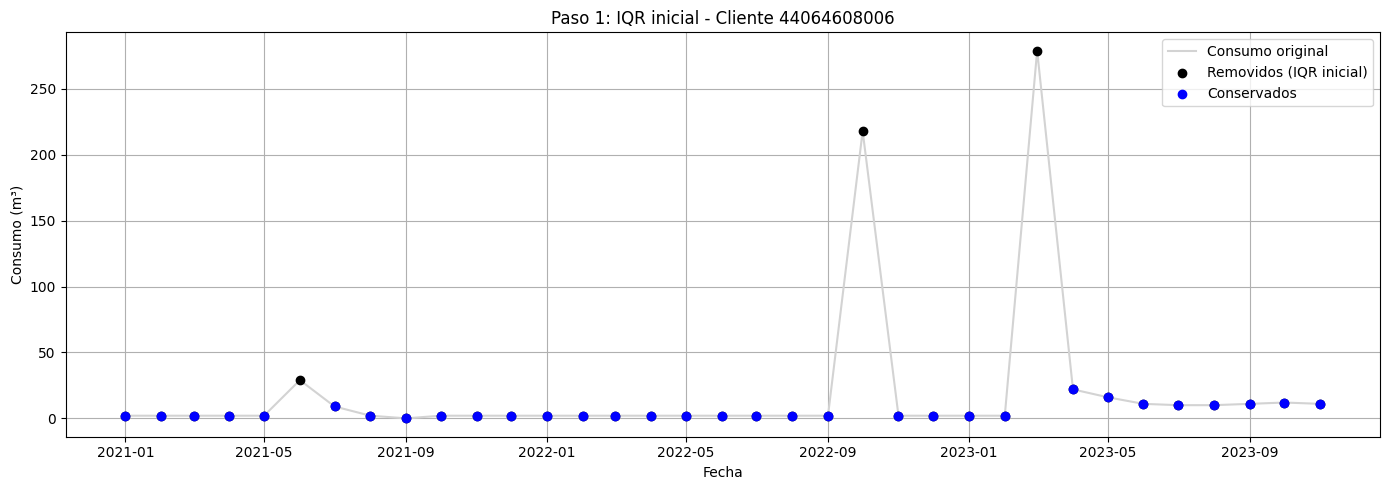

➡️ Paso 2: Media móvil calculada SOLO con datos filtrados


,data,qtd_consumo_medido_agua,media_movel_6
40310,2021-01-01,2,NaN
40311,2021-02-01,2,NaN
40312,2021-03-01,2,NaN
40313,2021-04-01,2,NaN
40314,2021-05-01,2,NaN
40315,2021-07-01,9,3
40316,2021-08-01,2,3
40317,2021-09-01,0,3
40318,2021-10-01,2,3
40319,2021-11-01,2,3


➡️ Paso 3: Dataset original con media móvil aplicada


,data,qtd_consumo_medido_agua,media_movel_6
40894,2021-01-01,2,NaN
40895,2021-02-01,2,NaN
40896,2021-03-01,2,NaN
40897,2021-04-01,2,NaN
40898,2021-05-01,2,NaN
40899,2021-06-01,29,NaN
40900,2021-07-01,9,3
40901,2021-08-01,2,3
40902,2021-09-01,0,3
40903,2021-10-01,2,3


➡️ Paso 4: Resultado final con z-score, residuo y outliers


,data,qtd_consumo_medido_agua,media_movel_6,residuo_mm,z_score_residuo,outlier_MM
40894,2021-01-01,2,NaN,NaN,NaN,False
40895,2021-02-01,2,NaN,NaN,NaN,False
40896,2021-03-01,2,NaN,NaN,NaN,False
40897,2021-04-01,2,NaN,NaN,NaN,False
40898,2021-05-01,2,NaN,NaN,NaN,False
40899,2021-06-01,29,NaN,NaN,NaN,False
40900,2021-07-01,9,3,6,-0,False
40901,2021-08-01,2,3,-1,-0,False
40902,2021-09-01,0,3,-3,-0,False
40903,2021-10-01,2,3,-1,-0,False


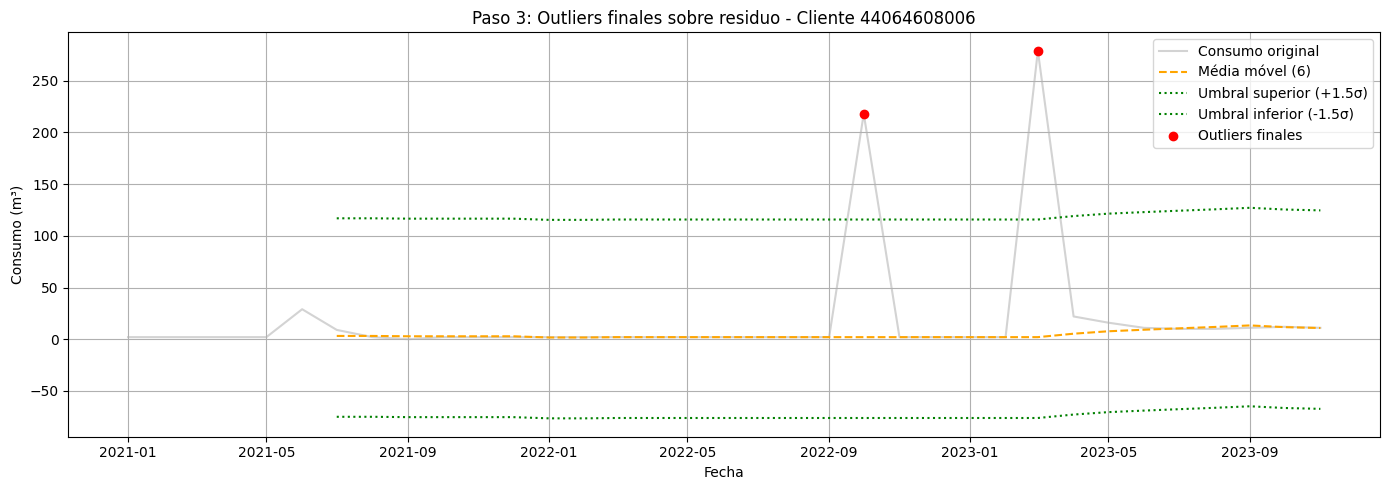

In [ ]:
# Paso 1: Remover outliers IQR iniciales
df_sin_outliers_iniciales = remover_outliers_iqr_por_cliente(df, col_consumo=col_consumo)
print("➡️ Paso 1: Datos SIN outliers iniciales (IQR)")
display(df_sin_outliers_iniciales[df_sin_outliers_iniciales["id_fornecimento"] == cliente_id_objetivo])

# Graficar lo que se eliminó visualmente
graficar_IQR_inicial(df, df_sin_outliers_iniciales, cliente_id_objetivo)

# Paso 2: Calcular media móvil (con datos limpios)
df_media_movel = calcular_media_movel(df_sin_outliers_iniciales, window=window, col_consumo=col_consumo)
print("➡️ Paso 2: Media móvil calculada SOLO con datos filtrados")
display(df_media_movel[df_media_movel["id_fornecimento"] == cliente_id_objetivo][["data", col_consumo, f"media_movel_{window}"]])

# Paso 3: Aplicar media móvil al dataset original
df_con_media = aplicar_media_movel_en_original(df, df_media_movel, window=window)
print("➡️ Paso 3: Dataset original con media móvil aplicada")
display(df_con_media[df_con_media["id_fornecimento"] == cliente_id_objetivo][["data", col_consumo, f"media_movel_{window}"]])

# Paso 4: Detectar outliers finales con z-score
df_resultado = detectar_outliers_final_zscore(df_con_media, col_consumo=col_consumo, window=window, z_threshold=1.5)
print("➡️ Paso 4: Resultado final con z-score, residuo y outliers")
display(df_resultado[df_resultado["id_fornecimento"] == cliente_id_objetivo][[
    "data", col_consumo, f"media_movel_{window}", "residuo_mm", "z_score_residuo", "outlier_MM"
]])

# Paso 5: Graficar outliers finales
graficar_outliers_finais(df_resultado, cliente_id_objetivo, window=window)

✅ PASO 1: Datos SIN outliers iniciales (IQR)


,data,qtd_consumo_medido_agua
40310,2021-01-01,2
40311,2021-02-01,2
40312,2021-03-01,2
40313,2021-04-01,2
40314,2021-05-01,2
40315,2021-07-01,9
40316,2021-08-01,2
40317,2021-09-01,0
40318,2021-10-01,2
40319,2021-11-01,2


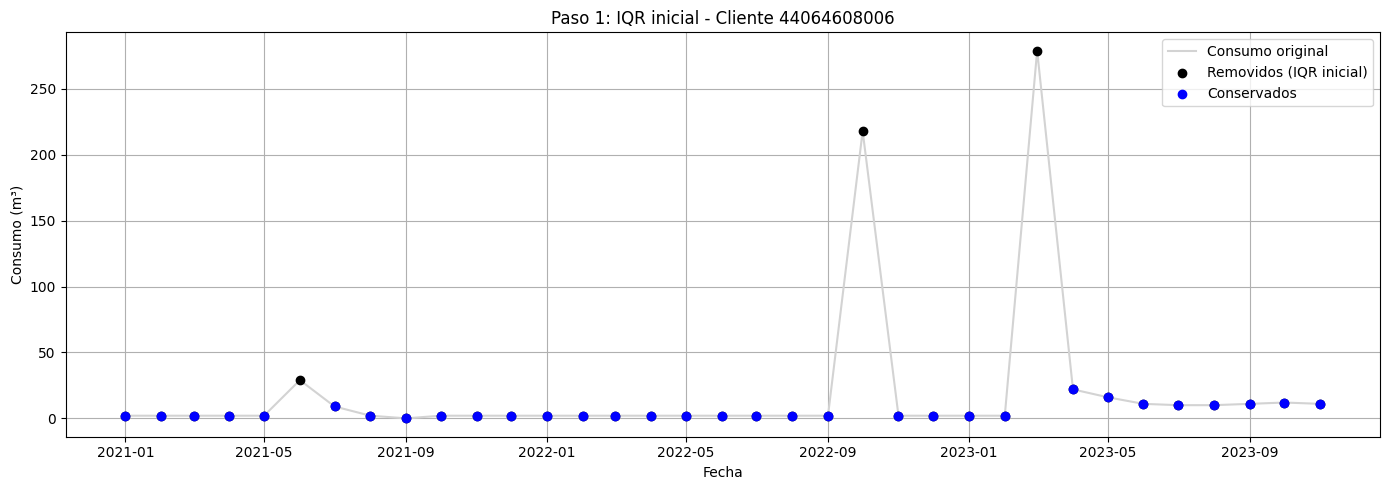

✅ PASO 2: Media móvil calculada con datos filtrados


,data,qtd_consumo_medido_agua,media_movel_6
40310,2021-01-01,2,NaN
40311,2021-02-01,2,NaN
40312,2021-03-01,2,NaN
40313,2021-04-01,2,NaN
40314,2021-05-01,2,NaN
40315,2021-07-01,9,3
40316,2021-08-01,2,3
40317,2021-09-01,0,3
40318,2021-10-01,2,3
40319,2021-11-01,2,3


✅ PASO 3: Media móvil aplicada al dataset original


,data,qtd_consumo_medido_agua,media_movel_6
40894,2021-01-01,2,NaN
40895,2021-02-01,2,NaN
40896,2021-03-01,2,NaN
40897,2021-04-01,2,NaN
40898,2021-05-01,2,NaN
40899,2021-06-01,29,NaN
40900,2021-07-01,9,3
40901,2021-08-01,2,3
40902,2021-09-01,0,3
40903,2021-10-01,2,3


✅ PASO 4: Residuo, z-score y detección de outliers


,Fecha,Consumo (real),Media Móvil (6),Residuo (real - MM),Z-Score,Outlier?
40894,2021-01-01,2,NaN,NaN,NaN,False
40895,2021-02-01,2,NaN,NaN,NaN,False
40896,2021-03-01,2,NaN,NaN,NaN,False
40897,2021-04-01,2,NaN,NaN,NaN,False
40898,2021-05-01,2,NaN,NaN,NaN,False
40899,2021-06-01,29,NaN,NaN,NaN,False
40900,2021-07-01,9,3,6,-0,False
40901,2021-08-01,2,3,-1,-0,False
40902,2021-09-01,0,3,-3,-0,False
40903,2021-10-01,2,3,-1,-0,False


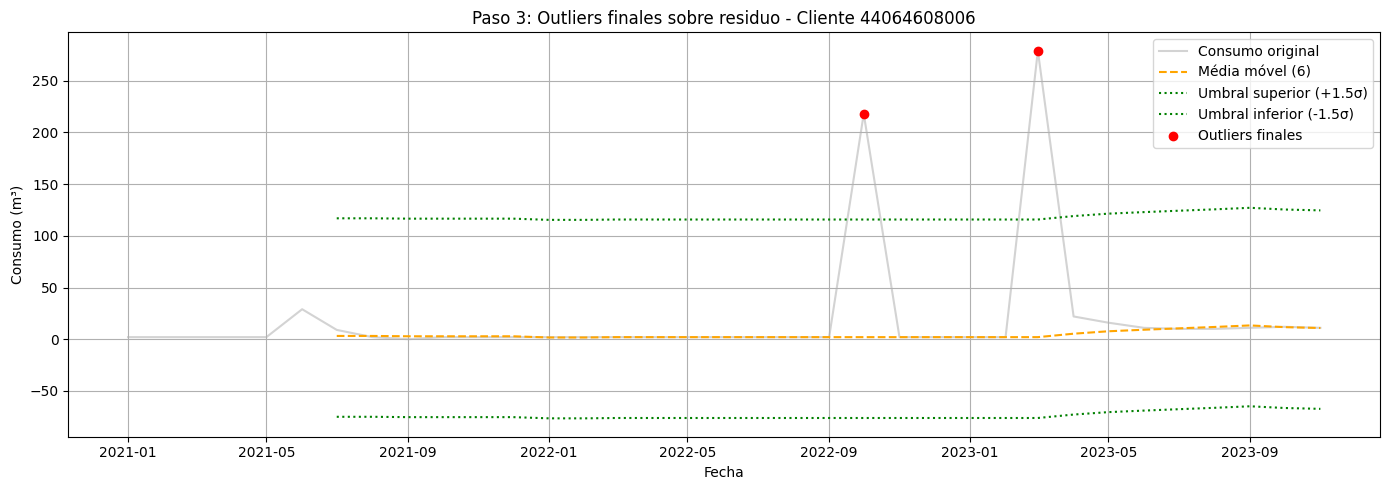

In [ ]:
# Paso 1: Remover outliers IQR iniciales
df_sin_outliers_iniciales = remover_outliers_iqr_por_cliente(df, col_consumo=col_consumo)
print("✅ PASO 1: Datos SIN outliers iniciales (IQR)")
df_step1 = df_sin_outliers_iniciales[df_sin_outliers_iniciales["id_fornecimento"] == cliente_id_objetivo]
display(df_step1[["data", col_consumo]])

# Gráfico visual del IQR
graficar_IQR_inicial(df, df_sin_outliers_iniciales, cliente_id_objetivo)

# Paso 2: Calcular media móvil
df_media_movel = calcular_media_movel(df_sin_outliers_iniciales, window=window, col_consumo=col_consumo)
print("✅ PASO 2: Media móvil calculada con datos filtrados")
df_step2 = df_media_movel[df_media_movel["id_fornecimento"] == cliente_id_objetivo]
display(df_step2[["data", col_consumo, f"media_movel_{window}"]])

# Paso 3: Aplicar media móvil al dataset original
df_con_media = aplicar_media_movel_en_original(df, df_media_movel, window=window)
print("✅ PASO 3: Media móvil aplicada al dataset original")
df_step3 = df_con_media[df_con_media["id_fornecimento"] == cliente_id_objetivo]
display(df_step3[["data", col_consumo, f"media_movel_{window}"]])

# Paso 4: Detectar outliers con z-score
df_resultado = detectar_outliers_final_zscore(df_con_media, col_consumo=col_consumo, window=window, z_threshold=1.5)
print("✅ PASO 4: Residuo, z-score y detección de outliers")
df_step4 = df_resultado[df_resultado["id_fornecimento"] == cliente_id_objetivo]

# Seleccionamos columnas clave y renombramos para que sea más claro
df_print = df_step4[[
    "data",
    col_consumo,
    f"media_movel_{window}",
    "residuo_mm",
    "z_score_residuo",
    "outlier_MM"
]].copy()

df_print.columns = [
    "Fecha",
    "Consumo (real)",
    f"Media Móvil ({window})",
    "Residuo (real - MM)",
    "Z-Score",
    "Outlier?"
]

display(df_print)

# Paso 5: Graficar el resultado final
graficar_outliers_finais(df_resultado, cliente_id_objetivo, window=window)